In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import warnings
from scipy.integrate import trapz

# suppress numpy overflow warnings
warnings.filterwarnings('ignore')

k_b = 1.380649e-23 #m^2 kg/s^2/K
q_e = 1.6e-19
h = 6.626176e-34
hbar = 1.054571e-34
ev_to_j = 1.6e-19


def fermi(eps, mu, T):
    eps *= ev_to_j
    mu *= ev_to_j
    return 1/(1+np.exp((eps-mu)/(k_b*T)))


# gives E_a in units of k_b
def fit(x, activation_energy, I_0):
    '''
    Function that activation energy is being fit to
    '''
    x = np.array(x)+1e-30
    return I_0 * np.exp(-activation_energy/ (k_b*x))

def fit_thermal_activation(temps, currents):
    '''
    Function to fit temperature and currents to thermal activation equation, may need to mess with values to get consistent fits
    :param temps: temperature array
    :param currents: current array
    :return: tuple (a fitted function that can be used on temperatures, (fitted activation energy, fitted I_0))
    '''
    fit_func = fit
    p0 = [1/1000*ev_to_j, .003]

    def residuals(x):
        activation_energy, I_0 = x
        fitted = fit(temps, activation_energy, I_0)
        return sum((fitted-currents)**2)

    out = scipy.optimize.minimize(residuals, p0,)

    ps, pcov = scipy.optimize.curve_fit(fit_func, np.array(temps), np.array(currents)
                                        , p0=p0)

    E_a, I_0 = ps
    f = lambda x, E_a = E_a, I_0= I_0: fit_func(x, E_a, I_0)
    return f, (E_a, I_0)

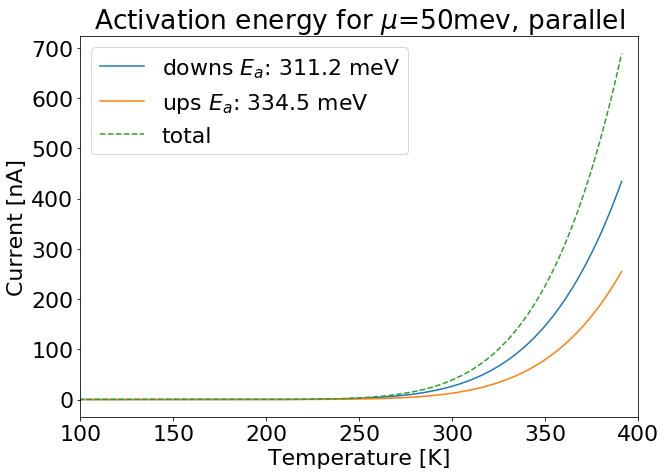

In [20]:
### Cell to fit thermal activation equation and display it ###
v_sd = 5/1000
left_pot = v_sd / 2
right_pot = -v_sd / 2
name = "50"  ### Use this to control the doping level being looked at, in meV
E_z = 0.0 * ev_to_j # Defines a manual shift, if wanted to be 0 keep this at 0, do not comment out!
data = np.load("data/testing_parallel.npy", allow_pickle=True)
_, energies, total, spin_downs, spin_ups = np.array(data) # unpack our data
doping_level = float(name)/1000
mu_left = doping_level+left_pot
mu_right = doping_level+right_pot

currents = []
ups = []
downs = []

### Function to ensure better fitting, can change the prefactor as wanted
t_max = lambda x: 200*np.exp(-(x*3)**2)
temps = np.linspace(0,t_max(doping_level), 200)


def middle_mask(x):
    '''
    Function to filter out small peaks in gap for antiparallel case
    '''
    return np.array([0 if abs(i) < 0.1 else 1 for i in x])

# calculate currents
for temp in temps:
    occupation_differences_up \
        = fermi(energies+E_z, mu_left, temp) - fermi(energies+E_z, mu_right, temp)

    occupation_differences_down \
        = fermi(energies-E_z, mu_left, temp) - fermi(energies-E_z, mu_right, temp)

    down_current = trapz(spin_downs * occupation_differences_down * middle_mask(energies), energies)
    up_current = trapz(spin_ups * occupation_differences_up * middle_mask(energies), energies)
    ups.append(up_current)
    downs.append(down_current)
    currents.append(up_current + down_current )


# plot currents
plt.figure(figsize=(10,7))

f, ps = fit_thermal_activation(temps, downs)
fitted = f(temps)
plt.plot(temps, (fitted)*1e9,label="downs $E_a$: {} meV".format(round(1000*ps[0]/ev_to_j,1)))

f, ps = fit_thermal_activation(temps, ups)
fitted = f(temps)
plt.plot(temps, (fitted)*1e9, label="ups $E_a$: {} meV".format(round(1000*ps[0]/ev_to_j,1)))


f, ps = fit_thermal_activation(temps, currents)
fitted = f(temps)
plt.plot(temps, (fitted)*1e9, "--",label="total",)# $E_a$: {} meV".format(round(1000*ps[0]/ev_to_j,1)))


plt.plot(temps, (downs))
plt.plot(temps, (ups))
plt.plot(temps, (currents),"--" )

plt.legend()
plt.xlabel("Temperature [K]")
plt.ylabel("Current [nA]")
plt.title("Activation energy for $\mu$={}mev, parallel".format(name))
plt.xlim(100,400)


font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

plt.rc('font', **font)
plt.savefig("graphs/Activation energies/activation {}mev".format(name))

plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:37<00:00,  5.39it/s]
No handles with labels found to put in legend.


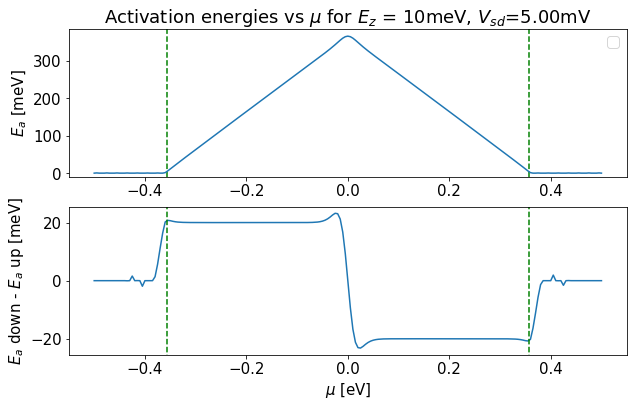

In [25]:
### Cell to calculate activation energies as a function of doping level ###

from tqdm import tqdm

v_sd = 5/1000
left_pot = v_sd / 2
right_pot = -v_sd / 2

_, energies, total, spin_downs, spin_ups = np.array(data)


levels = np.linspace(-0.5,.5, 201)
diffs = []
activation_energies = []
for doping_level in tqdm(levels):
    mu_left = doping_level+left_pot
    mu_right = doping_level+right_pot
    currents = []
    ups = []
    downs = []

    t_max = lambda x:  200*np.exp(-(x*3)**2)
    temps = np.linspace(0,t_max(doping_level), 200)
    for temp in temps:
        occupation_differences_up \
        = fermi(energies+E_z, mu_left, temp) - fermi(energies+E_z, mu_right, temp)

        occupation_differences_down \
            = fermi(energies-E_z, mu_left, temp) - fermi(energies-E_z, mu_right, temp)

        down_current = trapz(spin_downs * occupation_differences_down * middle_mask(energies), energies)
        up_current = trapz(spin_ups * occupation_differences_up * middle_mask(energies), energies)

        ups.append(up_current)
        downs.append(down_current)
        currents.append(up_current+down_current)

    f, ps = fit_thermal_activation(temps, currents)
    activation_energies.append(ps[0]/ev_to_j)
    f, ps_ups = fit_thermal_activation(temps, ups)
    f, ps_downs = fit_thermal_activation(temps, downs)
    diffs.append((ps_downs[0] - ps_ups[0]) / ev_to_j)


### Plot results
fig, axs = plt.subplots(2,figsize=(10,6))

band_start = 0.3567
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)
axs[0].plot(band_start * np.ones(50), np.linspace(-10, 500), "--", color="green")
axs[0].plot(-band_start * np.ones(50), np.linspace(-10, 500), "--", color="green")
axs[0].plot(levels,1000*np.array(activation_energies))

axs[0].legend()

axs[0].set_ylim(-10, max(activation_energies) * 1000 + 20)
axs[0].set_ylabel("$E_a$ [meV]")
axs[0].set_title("Activation energies vs $\mu$ for $E_z$ = 10meV, $V_{sd}$=%.2fmV" % (1000*v_sd))

axs[1].plot(levels, 1000 * np.array(diffs))
axs[1].set_ylabel("$E_a$ down - $E_a$ up [meV]")
axs[1].set_xlabel("$\mu$ [eV]")
axs[1].plot(band_start * np.ones(50), np.linspace(-1000, 1000), "--", color="green")
axs[1].plot(-band_start * np.ones(50), np.linspace(-1000, 1000), "--", color="green")

bound = 1000*max(abs(np.array(diffs))) * 1.1
axs[1].set_ylim(-bound,bound)


plt.savefig("graphs/150 angstrom dot/Activation energies/Activation energy for doping levels, manual 10meV")
plt.show()

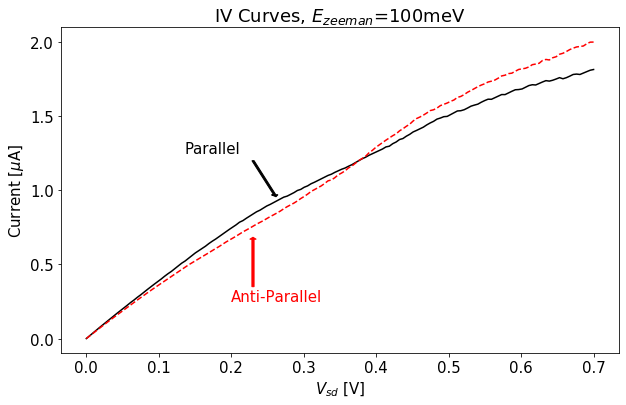

In [26]:
### Cell to plot and compare IV Curves generated from cluster_script.py ###

data = []
data2 = []
voltages = np.linspace(0, 0.7, 150)
data.extend(np.load("data/IV_Curve_Parallel_Z10meV.npy", allow_pickle=True))
data2.extend(np.load("data/IV_Curve_Antiparallel_Z10meV.npy", allow_pickle=True))

currents = []
currents2 = []
for current, energies, total, spin_downs, spin_ups in data[::]:
    currents.append(current*1e6 * q_e**2/hbar)

for current, energies, total, spin_downs, spin_ups in data2[::]:
    currents2.append(current*1e6 * q_e**2/hbar)

fig, axs = plt.subplots(1, figsize=(10,6))
axs = [axs]
axs[0].plot(voltages, currents, label = "Parallel", color="black")
axs[0].plot(voltages, currents2, "--",label = "Anti parallel", color="red")

plt.text(0.135,1.25,"Parallel", color="black")
plt.arrow(0.23, 1.2, .03, -.23, width = 0.003, edgecolor='none', color="black")
#
plt.text(0.2,0.25,"Anti-Parallel", color="red")
plt.arrow(0.23, 0.35, 0, .32, width = 0.003, edgecolor='none', color="red")
axs[0].set_xlabel("$V_{sd}$ [V]")
axs[0].set_ylabel("Current [$\mu$A]")


plt.title("IV Curves, $E_{zeeman}$=100meV")
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 20}

plt.rc('font', **font)

plt.savefig("graphs/final figs/IV Curves")
plt.show()
